## Read data
---

In [1]:
import zarr, numpy as np, nrrd

# filepaths
p = '/nrs/ahrens/ahrenslab/fleishmang/NewFullPipeline/F53/expanded/R1'
zarr_path = p + '/export.n5'
mask_path = p + '/segmentation/mask.nrrd'
rrna_path = '/c2/s0'
dapi_path = '/c3/s0'
expansion_factor = 2

# read lazy array and metadata
image_zarr = zarr.open(store=zarr.N5Store(zarr_path), mode='r')
image_meta = image_zarr.attrs.asdict()
spacing = np.array(image_meta['pixelResolution']['dimensions']) / expansion_factor
spacing = spacing[::-1]  # using zyx order
dapi_zarr = image_zarr[dapi_path]
rrna_zarr = image_zarr[rrna_path]

# get whole volumes at s3 and mask
dapi_s3, _ = nrrd.read(p + '/c3s3.nrrd')
rrna_s3, _ = nrrd.read(p + '/c2s3.nrrd')
mask, _ = nrrd.read(mask_path)
dapi_s3 = dapi_s3.transpose(2,1,0)
rrna_s3 = rrna_s3.transpose(2,1,0)
mask = mask.transpose(2,1,0)

# sanity checks
print(spacing)
print(dapi_zarr.shape, rrna_zarr.shape)
print(dapi_s3.shape, rrna_s3.shape, mask.shape)

[0.213335 0.11661  0.11661 ]
(1620, 9237, 5488) (1620, 9237, 5488)
(405, 1154, 686) (405, 1154, 686) (405, 1154, 686)


## Get histograms
---

1470 382 3.8481675392670156


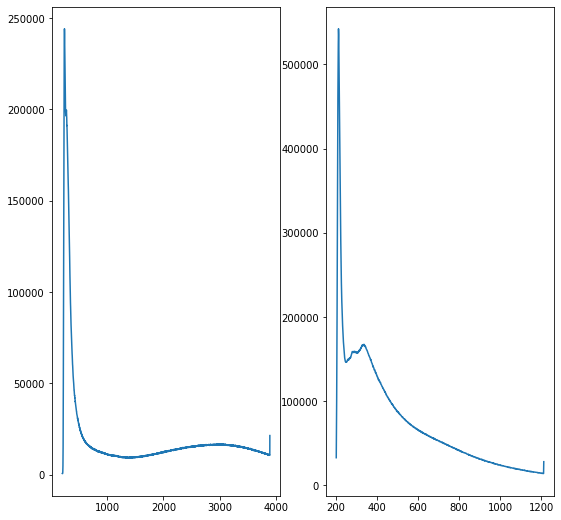

In [2]:
import matplotlib.pyplot as plt
from skimage import filters

mn, mx = np.percentile(dapi_s3, (8, 98))
dapi_hist, dapi_edges = np.histogram(dapi_s3[mask > 0], bins=int(mx - mn), range=(mn, mx))
mn, mx = np.percentile(rrna_s3, (8, 98))
rrna_hist, rrna_edges = np.histogram(rrna_s3[mask > 0], bins=int(mx - mn), range=(mn, mx))

t1 = filters.threshold_otsu(hist=dapi_hist)
t2 = filters.threshold_otsu(hist=rrna_hist)
ratio = t1 / t2
print(t1, t2, ratio)

figure, axes = plt.subplots(1, 2, figsize=(9, 9))
axes[0].plot(dapi_edges[1:], dapi_hist)
axes[1].plot(rrna_edges[1:], rrna_hist)

## Set preprocessing steps
---

In [3]:
from scipy.ndimage import gaussian_filter

### PREPROCESSING STEPS MUST ACCEPT A coords ARGUMENT EVEN IF IT IS NOT USED

# use rRna channel to improve nuclei boundaries
def combine_channels(image, coords):
    return image - (ratio - 1) * rrna_zarr[coords]

# enhance high resolution detail
def unsharp(image, sigma_one, weight, iterations, sigma_two, coords):
    image = image.astype(np.float32)
    for i in range(iterations):
        image = image + (image - gaussian_filter(image, sigma_one)) * weight
    image = gaussian_filter(image, sigma_two / spacing)
    image[image < 0] = 0
    return np.round(image).astype(np.uint16)

# package for distributed cellpose
preprocessing_steps = [
    (combine_channels, {}),
    (unsharp, {'sigma_one':1.0/spacing, 'weight':0.1, 'iterations':5, 'sigma_two':0.1}),
]

## Segment
---

In [4]:
# set up model
from cellpose.distribute import distributed_eval
import pickle

# # set model arguments
# model_kwargs = {'gpu':True, 'model_type':'cyto2', 'net_avg':True}

# # set evaluation arguments
# eval_kwargs = {'diameter':40,
#                'anisotropy':spacing[0] / spacing[1],
#                'z_axis':0,
#                'channels':[0,0],
#                'do_3D':True,
#                'min_size':15000,
#                'cellprob_threshold':1.0,
#                'net_avg':True,
# }

# # set blocksize
# blocksize = [256, 256, 256]

# # some dask config settings
# config = {
#     'distributed.worker.memory.target':0.9,
#     'distributed.worker.memory.spill':0.9,
#     'distributed.worker.memory.pause':0.9,
#     'distributed.comm.timeouts.connect':'300s',
# }

# # set cluster arguments
# cluster_kwargs = {
#     'project':'ahrens',
#     'ncpus':4,
#     'threads':1,
#     'min_workers':175,
#     'max_workers':175,
#     'queue':'gpu_rtx',
#     'job_extra':['-gpu "num=1"'],
#     'walltime':'12:00',
#     'config':config,
# }

# # run segmentation
# masks, boxes = distributed_eval(
#     dapi_zarr,
#     blocksize,
#     mask=mask,
#     preprocessing_steps=preprocessing_steps,
#     model_kwargs=model_kwargs,
#     eval_kwargs=eval_kwargs,
#     cluster_kwargs=cluster_kwargs,
#     write_path='./segmentation.zarr'
# )

# with open('./boxes.pkl', 'wb') as f:
#     pickle.dump(boxes, f)

masks = zarr.open('./segmentation.zarr', mode='r')
with open('./boxes.pkl', 'rb') as f:
    boxes = pickle.load(f)

/groups/scicompsoft/home/fleishmang/bin/miniconda3/envs/CircuitSeeker/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
IBM Spectrum LSF 10.1.0.0 build 601088, Apr 15 2022
Copyright International Business Machines Corp. 1992, 2016.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

  binary type: linux3.10-glibc2.17-x86_64


## Post-process

In [5]:
from cellpose.merge_and_split import merge_small_segments, relabel_segments, split_large_segments

# min_box_volume = 30000,
# new_labeling, boxes_processed = merge_small_segments(
#     masks, boxes, min_box_volume,
# )

# masks_processed = relabel_segments(
#     masks,
#     new_labeling,
#     write_path='./segmentation_merged_and_split.zarr',
#     cluster_kwargs={
#         'project':'ahrens',
#         'ncpus':1,
#         'threads':1,
#         'min_workers':100,
#         'max_workers':100,
#     },
# )

# # CAUTION: split algorithm writes data in place
# max_box_volume = 135000
# masks_processed, boxes_processed = split_large_segments(
#     masks_processed, boxes_processed, max_box_volume,
# )

# with open('./boxes_merged_and_split.pkl', 'wb') as f:
#     pickle.dump(boxes_processed, f)

masks_processed = zarr.open('./segmentation_merged_and_split.zarr', mode='r')
with open('./boxes_merged_and_split.pkl', 'rb') as f:
    boxes_processed = pickle.load(f)

## Make pyramid
---

In [6]:
from scipy.ndimage import zoom

# CAUTION: you need at least 400GB RAM for this!

# image data
zarr_path = p + '/export.n5'
zarr_image = zarr.open(store=zarr.N5Store(zarr_path), mode='r')
scales = ['s3', 's2', 's1']

# read mask data
masks_inmemory = masks_processed[...]

# resample
for scale in scales:
    ratio = np.array(zarr_image['/c3/' + scale].shape) / masks_inmemory.shape
    masks_scaled = zoom(masks_inmemory, ratio, order=0)
    nrrd.write('./masks_' + scale + '.nrrd', masks_scaled.transpose(2,1,0), compression_level=2)
    

## Inspect
---

In [7]:
volumes = []
for box in boxes_processed:
    volumes.append( np.prod( [x.stop - x.start for x in box] ))
volumes = np.array(volumes)

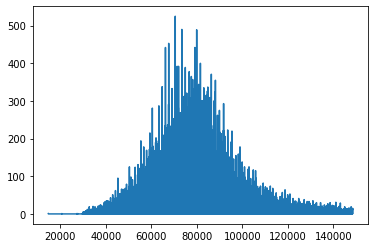

In [8]:
import matplotlib.pyplot as plt

mn, mx = np.percentile(volumes, (0, 97))
hist, edges = np.histogram(volumes, bins=10000, range=(mn, mx))
plt.plot(edges[1:], hist)
plt.show()